Coherent WaveBurst (cWB) is an open sofware used to search for gravitational-wave (GW) transients without assuming a waveform model. CWB identifies excess of power coherent in the network of GW detectors, and produces in output a list of coherent triggers. This triggers contains both noise and potential GW signals. To improve the detection efficiency a machine learning algorithm, the decision tree classifier XGBoost, is used to distingish between the two. This notebook shows how to train the classifier using cWB triggers, and how to use the network output.  

In [1]:
# Uncomment this line to install the dependencies
! pip install numpy pandas matplotlib xgboost scikit-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score

We define some function to plot the performance of XGBoost

In [3]:
def plot_confusion_matrix(y_test, preds):
    #input: targeted classes of the test dataset (y_test), and the XGBoost prediction on them
    #output: confusion matrix
    preds_round = [round(value) for value in preds]
    cm = confusion_matrix(y_test, preds_round, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
    disp.plot()
    plt.show()

def plot_xgboost_output(y_test, preds):
    #input: targeted classes of the test dataset (y_test), and the XGBoost prediction on them
    #output: histogram of the XGBoost output for the simulations and the background triggers
    sim_ind = np.argwhere(y_test == 1)
    bkg_ind = np.argwhere(y_test == 0)
    plt.figure(figsize=(6,3))
    plt.hist(preds[sim_ind],color='orange',label='Simulations',histtype='step',bins=20)
    plt.hist(preds[bkg_ind],color='blue',label='Background',histtype='step' ,bins=20)
    plt.yscale('log')
    plt.ylabel('Counts', fontsize=16)
    plt.xlabel('XGBoost output', fontsize=16)
    plt.legend()
    plt.show()

# Prepare files

At first, we open cWB output files. Note that cWB files are ROOT tree, here for convenience we upload .csv files that can be opened easily in python.
CWB output files are list of triggers, characterized by several features among with duration, central frequuency, energy....
 The first files contains White Noise Burst simulated signals injected in O3b data. The second file contains background triggers, i.e. triggers identifies by cWB in time-shifted O3b data.

In [4]:
#from google.colab import drive
#drive.mount('/content/drive/')

SIM = pd.read_csv("cWB_WNBsimulation_triggers_O3b_rho8.csv")
BKG = pd.read_csv("cWB_background_triggers_O3b_rho8.csv")
print("Number of simulations: ",len(SIM))
print("Bumber of background events: ",len(BKG))
#print the cWB parameters that characterize each trigger
print(SIM.columns)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Number of simulations:  57545
Bumber of background events:  340618
Index(['rho0', 'dur', 'band', 'central_freq', 'net_cc', 'time_L', 'snr_L',
       'snr_H', 'phi_cwb', 'theta_cwb', 'Qveto0', 'Qveto2', 'e_norm', 'e_cor',
       's_lag'],
      dtype='object')


The cWB smmary statistics included in SIM and BKG files are (for detail see [link](https://gwburst.gitlab.io/documentation/latest/html/running.html#trigger-parameters)):
- 'rho0' and 'rho1' : cWB ranking statistics Ref.
- 'dur', 'central_freq', 'band': duration, central frequency and bandwidth estimated in the time-frequency domain for all cWB resolutions
- 'net_cc': network correlation coefficient. in [0,1].
-'time_L','time_H': central times of the event for each detector
- 'snr_L','snr_H':  SNR^2 for each detector
-'phi_cwb','theta_cwb': estimated direction in cWB coordinates
- 'Qveto0','Qveto2': similarity to the waveform reconstructed by cWB with short duration glitches (blip-like)
- 'e_norm' : ratio between the total energy over the all resolution levels and the reconstructed energy of the event.
-'e_cor': sum of the off-diagonal term of cWB likelihood matrix (correlated energy)


We prepare the XGBoost training dataset. In this first example, we inpuut to XGBoost model only two cWB features (rho0 and netcc) for both simulations and backgroung classes.

In [5]:
#add a column named 'target' with a label for the binary classification: 1 for signal and 0 for noise
SIM['target']=1
BKG['target']=0

#concatenate simulation and background dataframes
data = pd.concat([SIM,BKG], ignore_index = True)
print(" number of simulation + background triggers: ", len(data))

#select the parameters to train the XGBoost model (called ML_list) from the previous list
ML_list = ['rho0','net_cc']

#split training and testing dataset (80% training, 20% testing)
# x data contains the cWB parameters (ML_list), y contains the label [0,1]
X_train, X_test, y_train, y_test = train_test_split(data[ML_list], data['target'], test_size=.2)

 number of simulation + background triggers:  398163


# First model


We create the XGBoost model, and we train it.

In [6]:
# create XGBoost model instance
bst = XGBClassifier(n_estimators=200, max_depth=4, learning_rate=1, objective='binary:logistic')

# fit/train the XGBoost model
bst.fit(X_train, y_train, verbose=True)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Next, we make predictions on the testing dataset, and we plot a confusion matrix to visualize the classification performance. We print also the Area Under the Receiver Operating Characteristic Curve (ROC AUC) score.

ROC AUC SCORE:  0.957


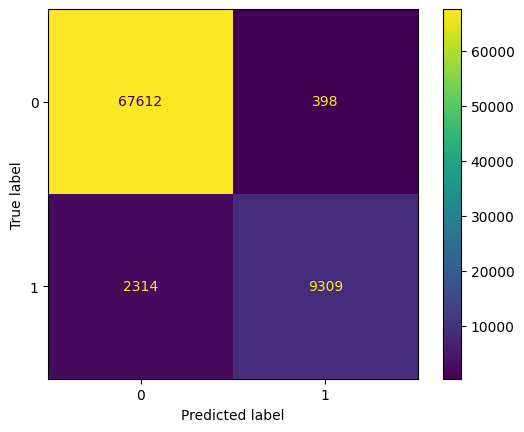

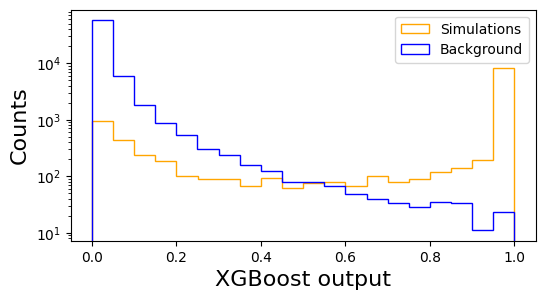

In [7]:
# make predictions on test dataset
preds = bst.predict_proba(X_test)[:,1]

print("ROC AUC SCORE: ",np.round(roc_auc_score(y_test, preds),3))

plot_confusion_matrix(y_test, preds)
plot_xgboost_output(y_test, preds)

The training dataset used is unbalanced: there are many more background triggers than simulations. This strongly affects the classification performance.
The following histogram shows cWB ranking statistic rho0 for simulation and background triggers:

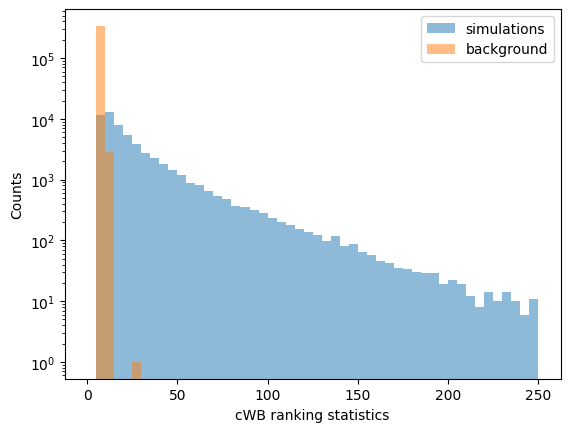

In [8]:
plt.hist(SIM['rho0'],label='simulations', range=(0,250),bins=50, alpha=0.5)
plt.hist(BKG['rho0'],label='background', range=(0,250),bins=50,alpha=0.5)
plt.legend()
plt.yscale('log')
plt.xlabel('cWB ranking statistics')
plt.ylabel('Counts')
plt.show()

# Second model

A possible solution to overcome this problem is to sample the number of background triggers. In cWB the sampling is achieved using a curve that depends on few parameters optimized during the tuning procedure.

 Here for simplicity, we just sub-samples randomly the number of background triggers in order to have the same number of samples for the two classes.

Number of background events after sub sampling:  53547


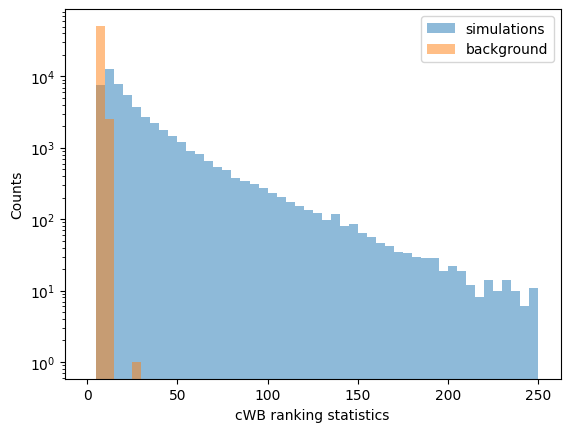

In [9]:
SIM_cut = SIM[SIM['rho0']>8]
BKG_cut = BKG[BKG['rho0']>8]
BKG_cut = BKG.sample(n=len(SIM_cut), weights=BKG_cut['rho0']**2)
print("Number of background events after sub sampling: ", len(BKG_cut))

plt.hist(SIM_cut['rho0'],label='simulations', range=(0,250),bins=50, alpha=0.5)
plt.hist(BKG_cut['rho0'],label='background', range=(0,250),bins=50,alpha=0.5)

plt.legend()
plt.yscale('log')
plt.xlabel('cWB ranking statistics')
plt.ylabel('Counts')
plt.show()

data_cut = pd.concat([SIM_cut,BKG_cut], ignore_index = True)

We repeat the same steps as before (creation of the XGBoost model, training and prediction on the testing dataset) with the more balanced training dataset:

ROC AUC SCORE:  0.957


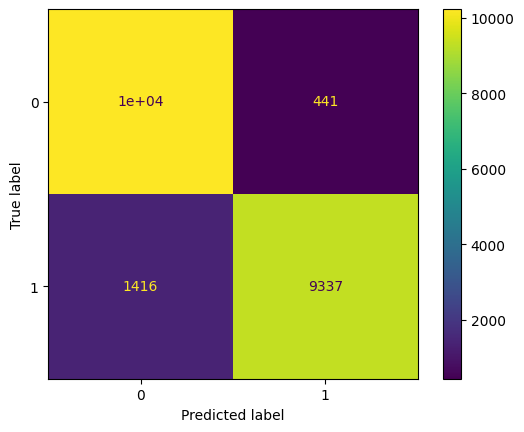

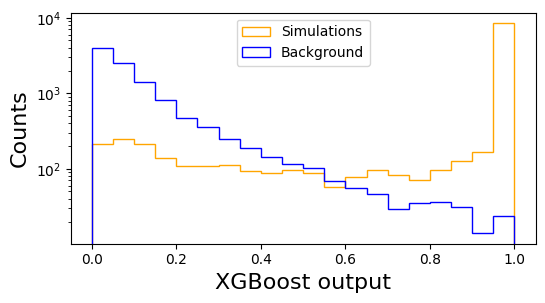

In [10]:
#we train a second XGBoost model with the 'balanced' traininng dataset (number of background events = number of simulations)
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(data_cut[ML_list], data_cut['target'], test_size=.2)

# create XGBoost model instance
bst_v2 = XGBClassifier(n_estimators=200, max_depth=4, learning_rate=1, objective='binary:logistic')

# fit XGBoost model
bst_v2.fit(X_train_v2, y_train_v2)

# make predictions on testing data
preds_v2 = bst_v2.predict_proba(X_test_v2)[:,1]

#plot confusion matrix and AUC score
print("ROC AUC SCORE: ",np.round(roc_auc_score(y_test_v2, preds_v2),3))

plot_confusion_matrix(y_test_v2, preds_v2)
plot_xgboost_output(y_test_v2, preds_v2)

# Third model

We train a third XGBoost model using the balanced dataset, and including in input more cWB parameters. In additon, we create a more complex network increasing the higher max_depth hyperparameter.

ROC AUC SCORE:  0.986


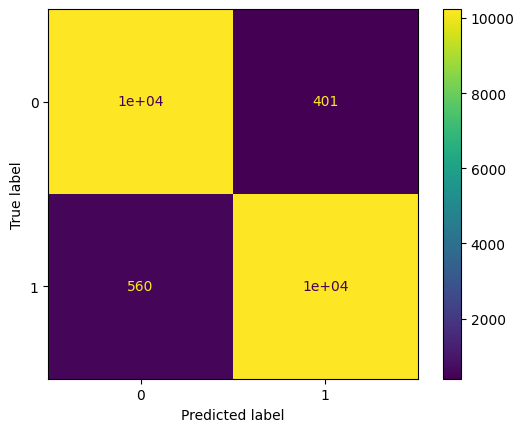

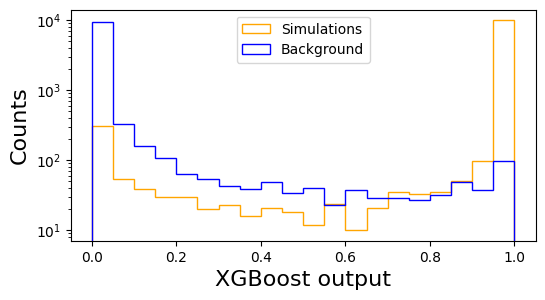

In [11]:
ML_list2 = ['rho0','net_cc','e_cor','e_norm','Qveto0','Qveto2']
X_train_v3, X_test_v3, y_train_v3, y_test_v3 = train_test_split(data_cut[ML_list2], data_cut['target'], test_size=.2)

# create XGBoost model instance
bst_v3 = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=1, objective='binary:logistic')

# fit XGBoost model
bst_v3.fit(X_train_v3, y_train_v3)

# make predictions on testing data
preds_v3 = bst_v3.predict_proba(X_test_v3)[:,1]

#plot confusion matrix and AUC score
print("ROC AUC SCORE: ",np.round(roc_auc_score(y_test_v3, preds_v3),3))

plot_confusion_matrix(y_test_v3, preds_v3)
plot_xgboost_output(y_test_v3, preds_v3)

The third model provides the most accurate classification among the three tested.

# Improvement in search sensitivity
cWB associates a FAR to each trigger comparing its ranking statistics with the bacground distribution. The FAR of an event with ranking statistic $\rho$ is $FAR(\rho') =$ (number of background event with $\rho > \rho'$  )/T, where T is the accumulated background time.

cWB computes a new ranking statistic using XGBoost output as $\rho_{xgb} = \rho * $XGB_output.


In [12]:
#we  concatenate X_test and y_test in the same dataframe
df = (pd.concat([X_test_v3, y_test_v3],axis = 1))
#we add a column with XGBoost outpt
df['XGB_output'] = preds_v3
#we add a column with new ranking statistic
df['rho_xgb'] = df['rho0']*df['XGB_output']

#we separate simuations and training
df_SIM = df[df['target']==1]
df_BKG = df[df['target']==0]

#Compute the inverse FAR (IFAR) for the simulation with the old ranking statistic (rho0) and with the machine-learning enhanced ranking statistics (rho_xgb).
IFAR=[]
IFAR_xgb=[]

T = 560 # years background time
for row_index, row in df_SIM.iterrows():            #we compute the IFAR for each simulation
    rho0 = df_SIM['rho0'][row_index]
    c = len(df_BKG[df_BKG['rho0']>rho0])            #count how many background triggers have higher rho
    rho_xgb = df_SIM['rho_xgb'][row_index]
    cc = len(df_BKG[df_BKG['rho_xgb']>rho_xgb])     #count how many background triggers have higher rho_xgb
    if c==0: c = 1
    if cc==0: cc = 1
    ifar = T/c                                      #ifar with old ranking statistic
    ifar_xgb = T/cc                                 #ifar with new ranking statistic
    IFAR.append(ifar)
    IFAR_xgb.append(ifar_xgb)


We show the increase of search sensitivity using XGBoost based ranking statistic in the last plot, which shows the number of recovered events versus IFAR.

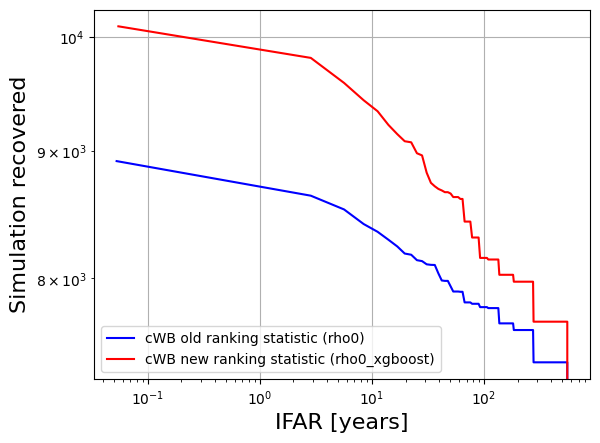

In [13]:
values, base = np.histogram(IFAR, bins=200)
values_xgb, base_xgb = np.histogram(IFAR_xgb, bins=200)

#evaluate the cumulative
cumulative = np.cumsum(values)
cumulative_xgb = np.cumsum(values_xgb)

# plot the cumulative function
plt.plot(base[:-1],len(IFAR)- cumulative, c='blue', label='cWB old ranking statistic (rho0)')
plt.plot(base_xgb[:-1],len(IFAR_xgb)- cumulative_xgb, c='red', label='cWB new ranking statistic (rho0_xgboost)')
plt.legend()
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("IFAR [years]", fontsize=16)
plt.ylabel("Simulation recovered", fontsize=16)
plt.show()

The above plot shows the enhancement in search sensitivity thansk to the third XGBoost model. At same IFAR threshold, more simulations are recovered using the machine-learning enhanced ranking statistics.